# Proyecto

Notas

Revisar  los hiper parametros de regresion para regulizacion en xgboost de regresion, verificar y ajustar hiperparametros de clasificacion.

Ver como hacer un balanceo en el nuevo de clasificacion

## Descripción del proyecto.


Participantes:


*   Elemento de la lista
*   Elemento de la lista
*   Elemento de la lista



## Importacion de librerias y del dataset.

In [338]:
# De momento importamos la libreria principal, conforme vaya pasando cada sección importaremos mas y mas librerias.

import pandas as pd

In [339]:
# Importamos nuestro dataset
data = pd.read_csv("predictive_maintenance.csv")
data.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

## Limpieza de datos

Primero veremos con cuantos datos contamos en el caso de nuestro dos target que ocuparemos tanto de Failure Type como Target. En el caso de Target son cuantas maquinas tienen fallas y cuantas no.

In [340]:
data['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

Como vemos nuestros ***Targets*** parecen desbalanceados por lo que aplicaremos diferentes tecnicas para tratar con este desbalanceo y no afecte a nuestros modelos.

In [341]:
data['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

Asi mmismo con este target, aplicaremos una tecnica que veremos mas adelante para el desbalanceo.

Verificamos que no haya valores nulos en nuestro dataset.

In [342]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Al no contar con valores nulos no es necesario hacer imputacion o eliminacion de columnas.

Eliminamos columnas que no ocuparemos

In [343]:
data = data.drop(columns=["UDI", "Product ID"])

# Mostramos como quedaria nuestro dataset
data.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure

## Mapeo de nuestros targets

En esta seccion corta lo que estamos haciendo es mapear nuestros targets para que los modelos puedan leerlo con mas facilidad.

PD: Ocupamos mapeo manual en lugar de usar One-HotEncoding o LabelEncoding por que se nos hace mas comodo y en nuestro caso el One-Hot no, nos serviria en nuestro caso, en el caso del LabelEncoding decidimos hacer el mapeo Manual por comidad ya que no son muchas variables categorias a mapear.

In [344]:
# Convertir la columna de tipo a valores numéricos


# Minutos de desgaste
data['Type'] = data['Type'].map({'L': 2, 'M': 3, 'H': 5})


# Aplicar Label Encoding
data['Failure Type'] = data['Failure Type'].map({
    "No Failure": 1,
    "Heat Dissipation Failure": 2,
    "Power Failure": 3,
    "Overstrain Failure": 4,
    "Tool Wear Failure": 5,
    "Random Failures": 6
})

In [345]:
data.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     3                298.1                    308.6                    1551   
1     2                298.2                    308.7                    1408   
2     2                298.1                    308.5                    1498   
3     2                298.2                    308.6                    1433   
4     2                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target  Failure Type  
0         42.8                0       0             1  
1         46.3                3       0             1  
2         49.4                5       0             1  
3         39.5                7       0             1  
4         40.0                9       0             1

##Visualización de las caracteristicas


In [346]:
data.describe()

Type  Air temperature [K]  Process temperature [K]  \
count  10000.000000         10000.000000             10000.000000   
mean       2.600600           300.004930               310.005560   
std        0.917477             2.000259                 1.483734   
min        2.000000           295.300000               305.700000   
25%        2.000000           298.300000               308.800000   
50%        2.000000           300.100000               310.100000   
75%        3.000000           301.500000               311.100000   
max        5.000000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  \
count            10000.000000  10000.000000     10000.000000  10000.000000   
mean              1538.776100     39.986910       107.951000      0.033900   
std                179.284096      9.968934        63.654147      0.180981   
min               1168.000000      3.800000         0.000000      0.000000   
25%               1423.000000     33.200000        53.000000      0.000000   
50%               1503.000000     40.100000       108.000000      0.000000   
75%               1612.000000     46.800000       162.000000      0.000000   
max               2886.000000     76.600000       253.000000      1.000000   

       Failure Type  
count  10000.000000  
mean       1.080600  
std        0.479507  
min        1.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        6.000000

In [347]:
import matplotlib.pyplot as plt

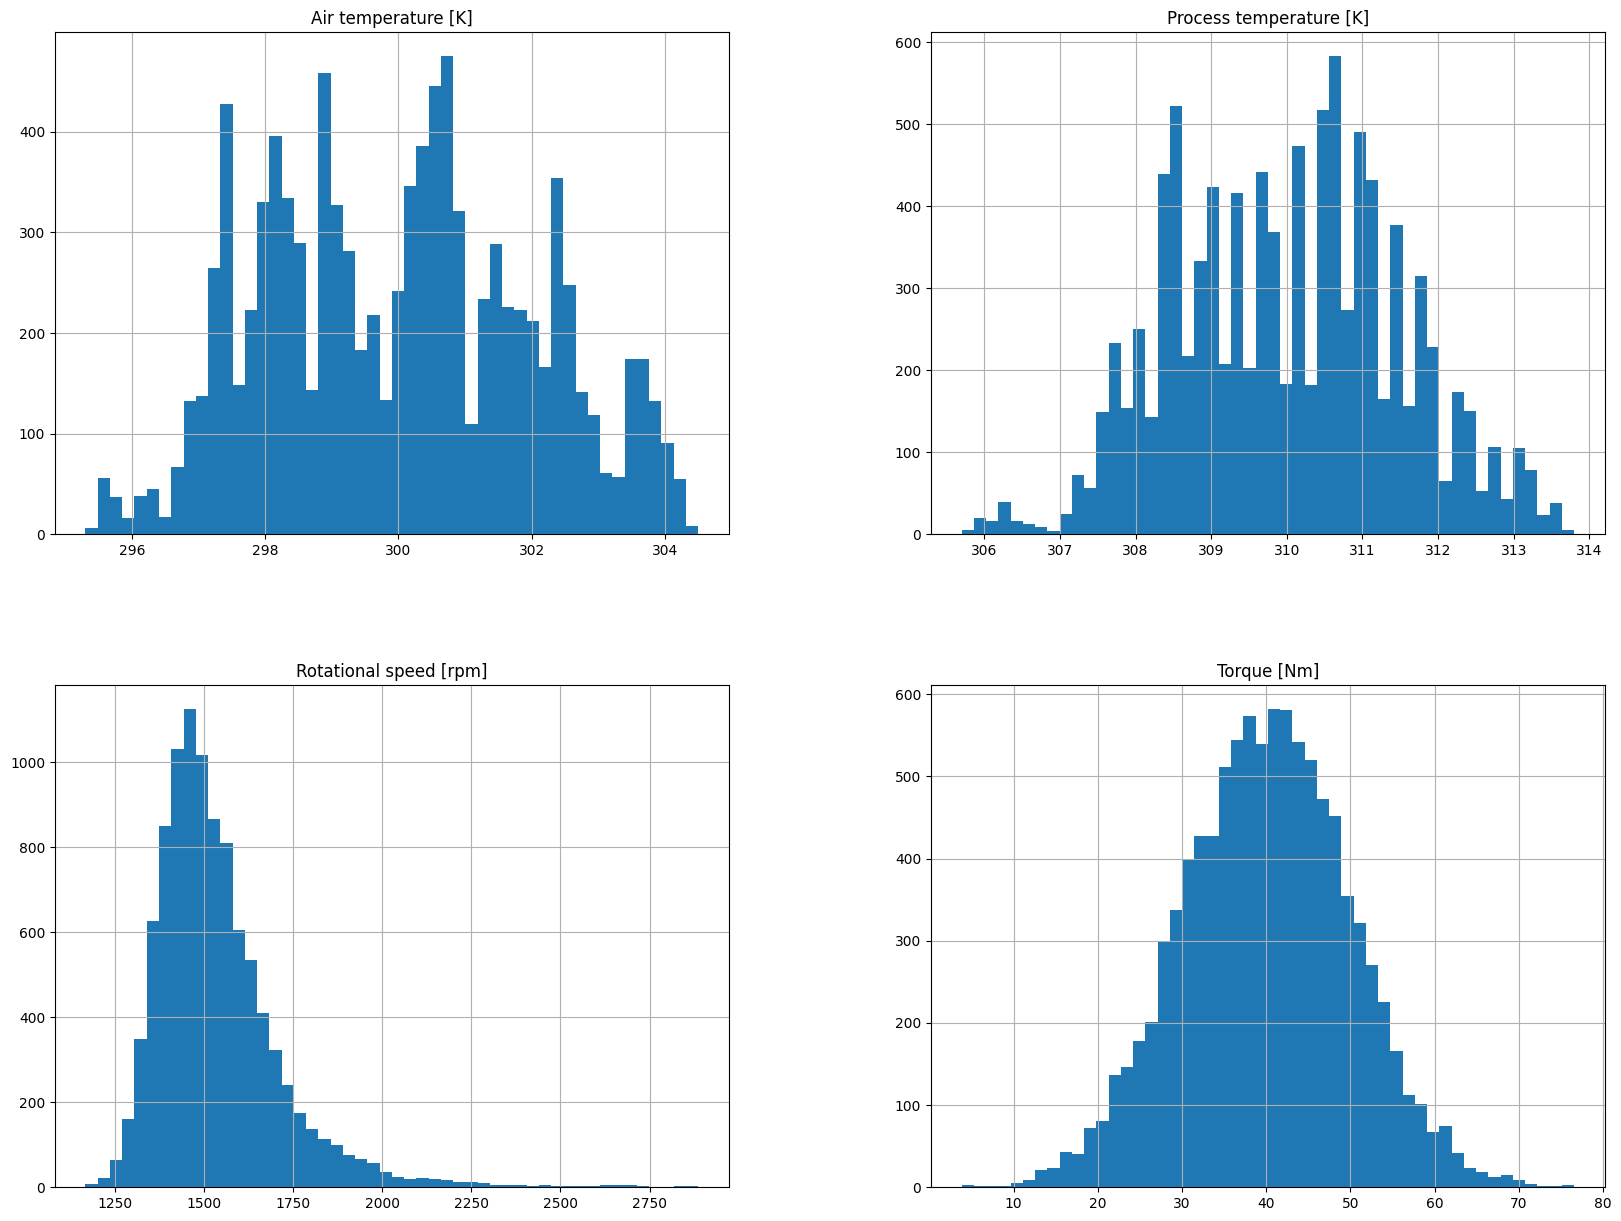

In [348]:
data[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]']].hist(bins=50, figsize=(20,15))
plt.show()

# Mostrar el gráfico
plt.show()

## Boxplot

Ahora verificamos mediante boxplots para ver si hay valores atipicos, dato por dato.

El cual los colores **salmon** seran boxplots **sin valores** atipicos.

---

Y el color **rojo** seran boxplot **con valores** atipicos.

### Temperatura del aire

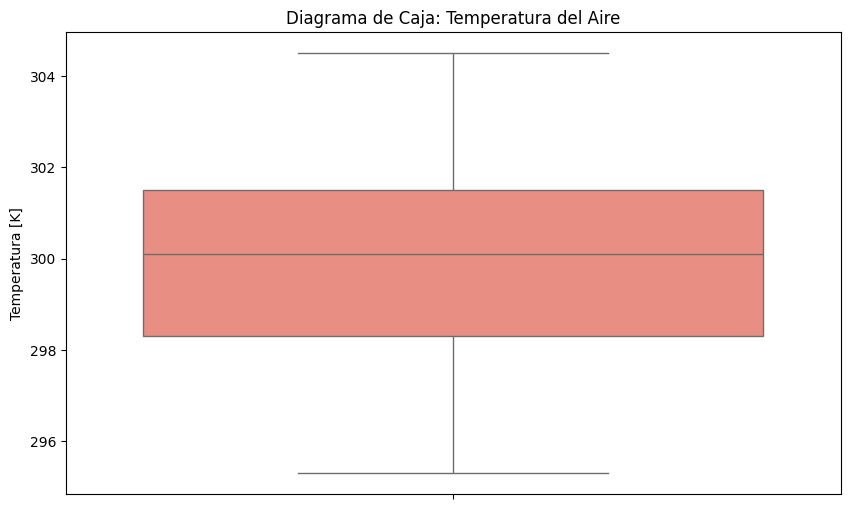

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un boxplot para visualizar valores atípicos en la temperatura del aire
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Air temperature [K]'], color='salmon')
plt.title('Diagrama de Caja: Temperatura del Aire')
plt.ylabel('Temperatura [K]')
plt.show()

*Sin valores atipicos*

### Temperatura del proceso

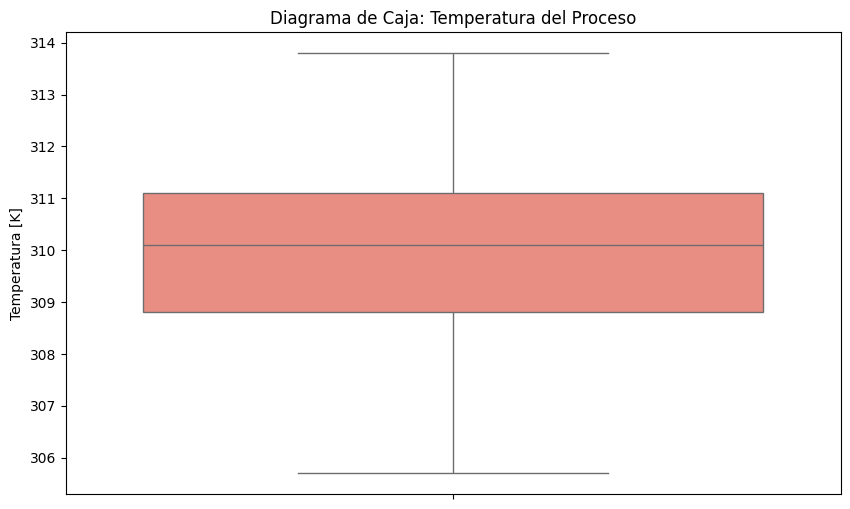

In [350]:
# Crear un boxplot para visualizar valores atípicos en la temperatura del proceso
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Process temperature [K]'], color='salmon')
plt.title('Diagrama de Caja: Temperatura del Proceso')
plt.ylabel('Temperatura [K]')
plt.show()

*Sin valores atipicos*

### Velocidad rotacional

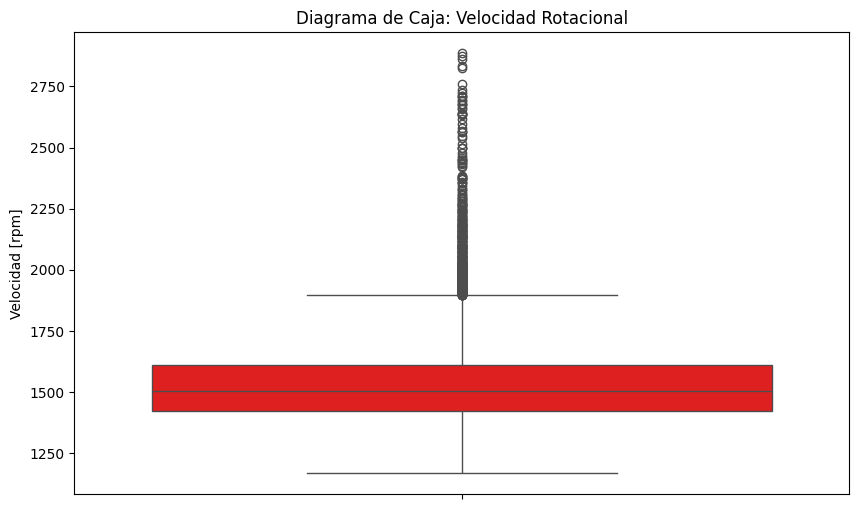

In [351]:
# Crear un boxplot para visualizar valores atípicos en la velocidad rotacional
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Rotational speed [rpm]'], color="red")
plt.title('Diagrama de Caja: Velocidad Rotacional')
plt.ylabel('Velocidad [rpm]')
plt.show()

*Con valores atipicos*

#### Tratamiento de valores atipicos

In [352]:
# Calcular cuartiles e IQR
Q1, Q3 = data['Rotational speed [rpm]'].quantile([0.25, 0.75])
IQR = Q3 - Q1

# Definir límites de valores atípicos
lim_inf, lim_sup = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = (data['Rotational speed [rpm]'] < lim_inf) | (data['Rotational speed [rpm]'] > lim_sup)
num_outliers = outliers.sum()

# Reemplazar valores atípicos
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].clip(lim_inf, lim_sup)
num_reemplazados = num_outliers  # Ya que cada outlier se reemplaza

# Mostrar resultados
print(f"Cantidad de valores atípicos detectados: {num_outliers}")
print(f"Cantidad de valores reemplazados: {num_reemplazados}")

Cantidad de valores atípicos detectados: 418
Cantidad de valores reemplazados: 418


### Torque

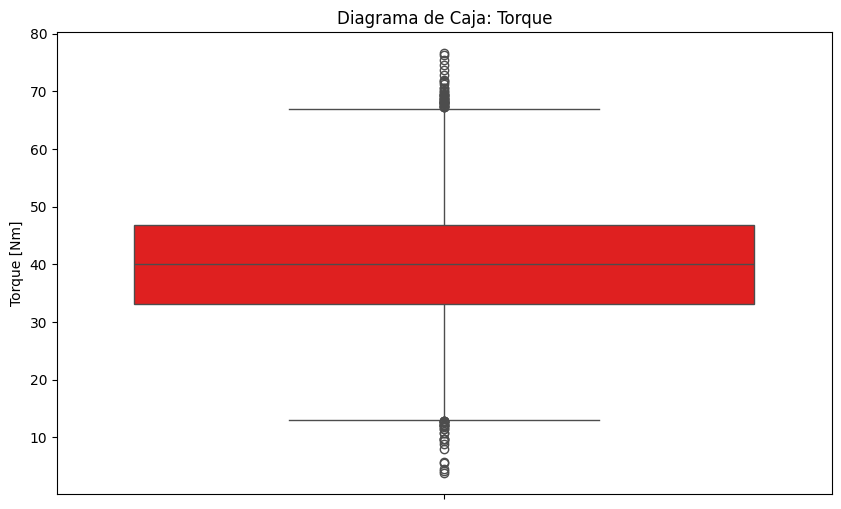

In [353]:
# Crear un boxplot para visualizar valores atípicos en el torque
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Torque [Nm]'], color='red')
plt.title('Diagrama de Caja: Torque')
plt.ylabel('Torque [Nm]')
plt.show()

*Con valores atipicos*

In [354]:
# Calcular cuartiles e IQR
Q1, Q3 = data['Torque [Nm]'].quantile([0.25, 0.75])
IQR = Q3 - Q1

# Definir límites de valores atípicos
lim_inf, lim_sup = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = (data['Torque [Nm]'] < lim_inf) | (data['Torque [Nm]'] > lim_sup)
num_outliers = outliers.sum()

# Reemplazar valores atípicos
data['Torque [Nm]'] = data['Torque [Nm]'].clip(lim_inf, lim_sup)
num_reemplazados = num_outliers  # Cada outlier es reemplazado

# Mostrar resultados
print(f"Cantidad de valores atípicos detectados: {num_outliers}")
print(f"Cantidad de valores reemplazados: {num_reemplazados}")

Cantidad de valores atípicos detectados: 69
Cantidad de valores reemplazados: 69


### Tool Wear (Corregir)

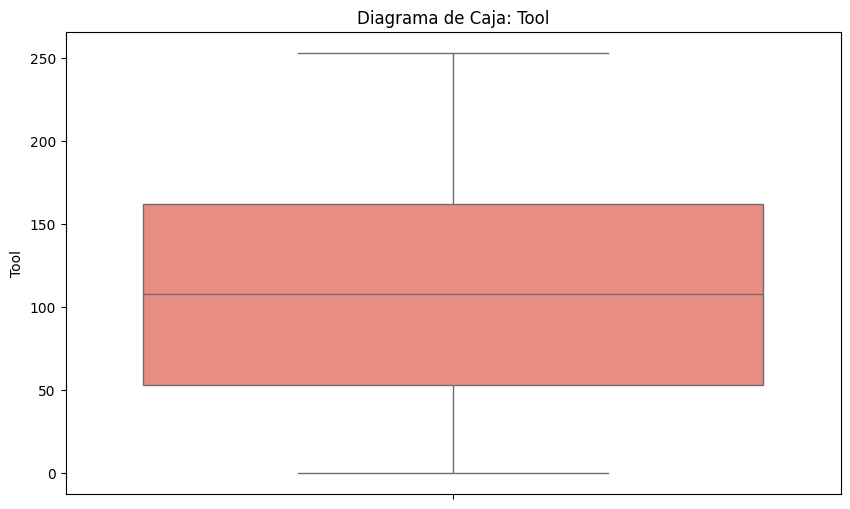

In [355]:
# Crear un boxplot para visualizar valores atípicos  tool weear (Corregir)
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Tool wear [min]'], color='salmon')
plt.title('Diagrama de Caja: Tool')
plt.ylabel('Tool')
plt.show()

*Sin valores atipicos*

## Modelo de Regresión

In [356]:
# Variables independientes (características)
x_regresion = data[['Torque [Nm]', 'Air temperature [K]', 'Process temperature [K]']]

# Variable dependiente (objetivo)
y_regresion = data['Rotational speed [rpm]']

### Correlacion de Caracteristicas respecto a Rotational Speed

In [357]:
# Calcular la matriz de correlación
correlacion_matrix = data.corr()

# Extraer la correlación de las features con 'Rotational speed [rpm]'
correlacion_target = correlacion_matrix["Rotational speed [rpm]"].sort_values(ascending=False)

# Mostrar las correlaciones
correlacion_target


Rotational speed [rpm]     1.000000
Air temperature [K]        0.021305
Process temperature [K]    0.019892
Tool wear [min]            0.002496
Type                      -0.001903
Failure Type              -0.088975
Target                    -0.130467
Torque [Nm]               -0.911734
Name: Rotational speed [rpm], dtype: float64

Podemos ver que hay algunas correlaciones muy bajas y algunas correlaciones negativas la cual ocuparemos para modificar las features que ocuparemos.

Torque [Nm]: -0.875 (correlación negativa fuerte)

Air temperature [K]: 0.0227 (correlación muy baja)

Process temperature [K]: 0.0193 (correlación muy baja)

### HeatMap

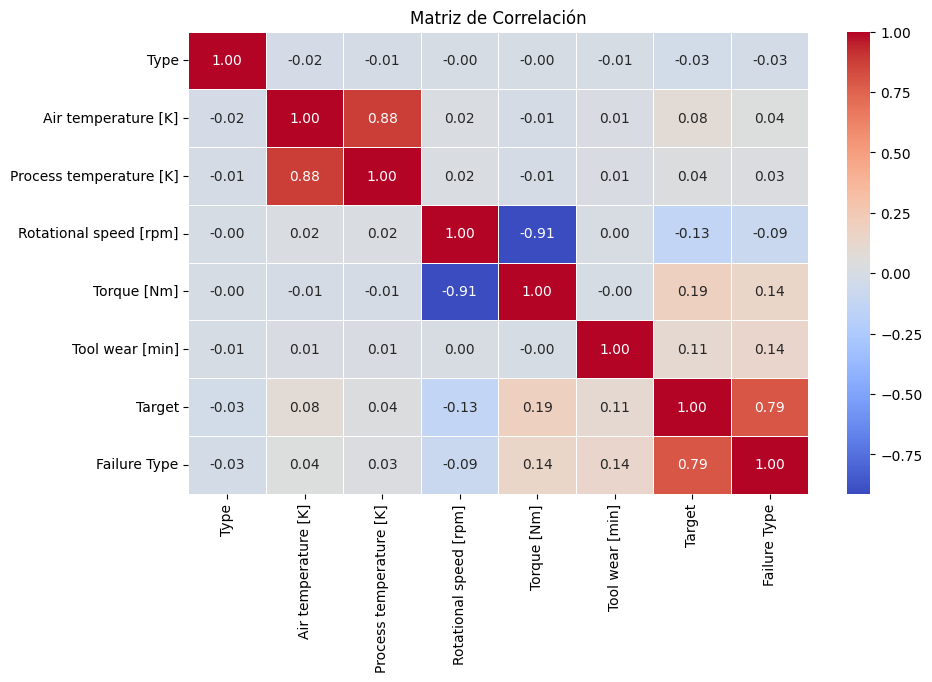

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlacion_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()


###Escalado de Datos


Escalamos los datos para que nuestros modelos puedan leerlo de una manera mas sencilla.

En nuestro caso utilizaremos conforme nos de mejor precision nuestro modelos entre MinMaxScaler y StandarScaler

In [359]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Crear una instancia del escalador
scaler_min_max = MinMaxScaler()
scaler_standar = StandardScaler()

# Ajustar y transformar los datos
x_escalado_min_max = scaler_min_max.fit_transform(x_regresion)  # X es el conjunto de datos y esta escalado con MinMaxScaler()
x_escalado_standar = scaler_standar.fit_transform(x_regresion)  # X es el conjunto de datos y esta escalado con StandardScaler()

### Dividimos el conjunto de datos

Insertamos nuestros datos escalados y luego dividimos dichos datos conforme vayamos probando la precision.

In [360]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(x_escalado_standar, y_regresion, test_size=0.3, random_state=42)


### Importamos y creamos nuestro modelo

En esta parte importaremos la librerias para instanciar nuestro modelo y lo entrenaremos conforme los parametros correspondientesen nuestro caso ocuparemos haremos uso de RandomForest y XGBoost.
Para saber cual se adapta mas a nuestros datos

In [361]:
# Importamos la librerias de RandomFores y XGBoost
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Crear el modelo

model_rf_r = RandomForestRegressor(
    n_estimators=400,      # Aumentamos el número de árboles para mejorar la estabilidad
    max_depth=5,           # Reducimos la profundidad para evitar overfitting
    min_samples_split=20,  # Requiere más muestras para hacer una división
    min_samples_leaf=10,   # Cada hoja debe tener al menos 10 muestras
    max_features=0.7,      # Reducimos el número de características usadas por árbol
    random_state=42
)

model_xgb = XGBRegressor(
    n_estimators=500,   # Mantiene el número de árboles
    learning_rate=0.05,  # Velocidad de aprendizaje moderada
    max_depth=1,        # Aumenta ligeramente la profundidad para captar más patrones
    reg_lambda=10,       # Regularización L2 (reduce pesos grandes)
    reg_alpha=5,      # Regularización L1 (elimina pesos innecesarios)
    subsample=0.8,      # Usa el 80% de los datos por árbol
    colsample_bytree=0.8, # Usa el 80% de las características en cada árbol
    random_state=42
)

model_gbm = GradientBoostingRegressor(
    n_estimators=400,              # Incrementa el número de árboles
    max_depth=5,                    # Mantén la profundidad moderada
    learning_rate=0.01,             # Reduce la tasa de aprendizaje
    random_state=42,                # Semilla aleatoria para reproducibilidad
    min_samples_split=20,           # Aumenta el número mínimo de muestras para dividir
    min_samples_leaf=10,            # Aumenta el número mínimo de muestras en cada hoja
    subsample=0.8,                  # Usa el 80% de los datos para cada árbol
    max_features="sqrt"             # Usa la raíz cuadrada de las características
)

En este caso tambien agregamos otros hiperparametros como regulizacion, tiempo de entrenamiento, etc.
Para que almenos ligeramente

### Entrenamiento del modelo

Entrenamos nuestro modelo con los datos divididos en nuetros caso un 70% de entrenamiento tanto de X y Y

In [362]:
# Entrenar el modelo con los datos de entrenamiento
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [363]:
# Entrenamos el modelo con Randon Forest
model_rf_r.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=0.7, min_samples_leaf=10,
                      min_samples_split=20, n_estimators=400, random_state=42)

In [364]:
# Entramos el modelo con Gradiendt Boosting
model_gbm.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, max_features='sqrt',
                          min_samples_leaf=10, min_samples_split=20,
                          n_estimators=400, random_state=42, subsample=0.8)

## Predicciones

XGBOOST

Hacemos nuestra predicción de y conforme los datos de prueba de x

In [365]:
# Hacer predicciones con el conjunto de prueba
y_pred = model_xgb.predict(X_test)

Random Forest

In [366]:
y_pred_rf_r = model_rf_r.predict(X_test)

 Gradient Boosting

In [367]:
y_pred_gbm = model_gbm.predict(X_test)

## Graficas

En esta grafica veremos que tanto se separa nuestros valores de nuestro modelo. Viendo que tan preciso fue.

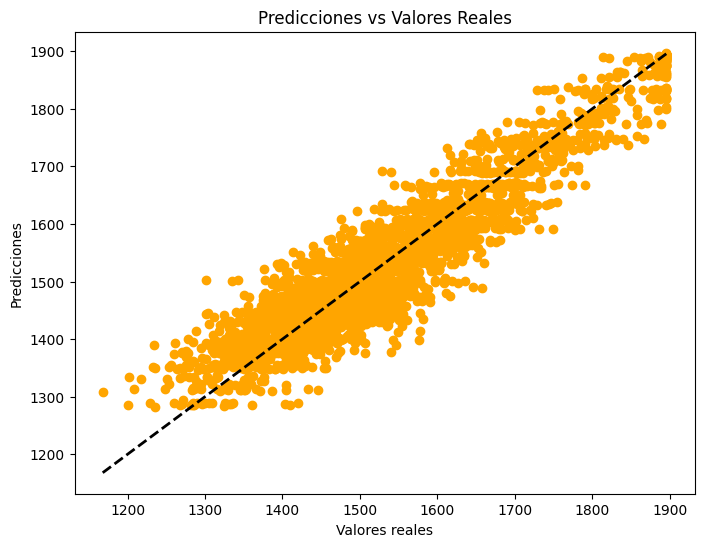

In [368]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

## Metricas

Ahora utilizaremos metricas como MAE, MSE, RMSE y R2 para saber que tanto se equivoca nuestro modelo, si es que tenemos errores grandes y la "precision" de nuestro modelo.

In [369]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Cálculo de métricas para entrenamiento
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Cálculo de métricas para prueba
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Regresión:")
print("Entrenamiento:")
print(f"  MAE: {mae_train:.4f}")
print(f"  MSE: {mse_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  R^2 Score: {r2_train:.4f}")

print("\nPrueba:")
print(f"  MAE: {mae_test:.4f}")
print(f"  MSE: {mse_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R^2 Score: {r2_test:.4f}")


Reporte de Evaluación del Modelo de Regresión:
Entrenamiento:
  MAE: 38.0690
  MSE: 2338.4352
  RMSE: 48.3574
  R^2 Score: 0.8946

Prueba:
  MAE: 39.1466
  MSE: 2495.8933
  RMSE: 49.9589
  R^2 Score: 0.8867


Como podemos ver nuestro modelo generaliza muy bien, por lo que no tiene tanto subajuste como sobreajuste.

In [370]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en entrenamiento y prueba
y_train_pred_rf_r = model_rf_r.predict(X_train)
y_test_pred_rf_r = model_rf_r.predict(X_test)

# Cálculo de métricas para entrenamiento
mae_train_rf_r = mean_absolute_error(y_train, y_train_pred_rf_r)
mse_train_rf_r = mean_squared_error(y_train, y_train_pred_rf_r)
rmse_train_rf_r = np.sqrt(mse_train_rf_r)
r2_train_rf_r = r2_score(y_train, y_train_pred_rf_r)

# Cálculo de métricas para prueba
mae_test_rf_r = mean_absolute_error(y_test, y_test_pred_rf_r)
mse_test_rf_r = mean_squared_error(y_test, y_test_pred_rf_r)
rmse_test_rf_r = np.sqrt(mse_test_rf_r)
r2_test_rf_r = r2_score(y_test, y_test_pred_rf_r)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Regresión:")
print("Entrenamiento:")
print(f"  MAE: {mae_train_rf_r:.4f}")
print(f"  MSE: {mse_train_rf_r:.4f}")
print(f"  RMSE: {rmse_train_rf_r:.4f}")
print(f"  R^2 Score: {r2_train_rf_r:.4f}")

print("\nPrueba:")
print(f"  MAE: {mae_test_rf_r:.4f}")
print(f"  MSE: {mse_test_rf_r:.4f}")
print(f"  RMSE: {rmse_test_rf_r:.4f}")
print(f"  R^2 Score: {r2_test_rf_r:.4f}")


Reporte de Evaluación del Modelo de Regresión:
Entrenamiento:
  MAE: 39.1591
  MSE: 2406.6995
  RMSE: 49.0581
  R^2 Score: 0.8915

Prueba:
  MAE: 40.3533
  MSE: 2578.7137
  RMSE: 50.7810
  R^2 Score: 0.8829


In [371]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en entrenamiento y prueba
y_train_pred_gbm = model_gbm.predict(X_train)
y_test_pred_gbm = model_gbm.predict(X_test)

# Cálculo de métricas para entrenamiento
mae_train_gbm = mean_absolute_error(y_train, y_train_pred_gbm)
mse_train_gbm = mean_squared_error(y_train, y_train_pred_gbm)
rmse_train_gbm = np.sqrt(mse_train_gbm)
r2_train_gbm = r2_score(y_train, y_train_pred_gbm)

# Cálculo de métricas para prueba
mae_test_gbm = mean_absolute_error(y_test, y_test_pred_gbm)
mse_test_gbm = mean_squared_error(y_test, y_test_pred_gbm)
rmse_test_gbm = np.sqrt(mse_test_gbm)
r2_test_gbm = r2_score(y_test, y_test_pred_gbm)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Regresión:")
print("Entrenamiento:")
print(f"  MAE: {mae_train_gbm:.4f}")
print(f"  MSE: {mse_train_gbm:.4f}")
print(f"  RMSE: {rmse_train_gbm:.4f}")
print(f"  R^2 Score: {r2_train_gbm:.4f}")

print("\nPrueba:")
print(f"  MAE: {mae_test_gbm:.4f}")
print(f"  MSE: {mse_test_gbm:.4f}")
print(f"  RMSE: {rmse_test_gbm:.4f}")
print(f"  R^2 Score: {r2_test_gbm:.4f}")

Reporte de Evaluación del Modelo de Regresión:
Entrenamiento:
  MAE: 38.3935
  MSE: 2292.5130
  RMSE: 47.8802
  R^2 Score: 0.8966

Prueba:
  MAE: 40.9753
  MSE: 2626.4062
  RMSE: 51.2485
  R^2 Score: 0.8808


## Votacion Suave

In [384]:
from sklearn.ensemble import VotingRegressor

# Crear el modelo de votación suave
voting_model_soft = VotingRegressor(estimators=[
    ('rf', model_rf_r),
    ('gbr', model_gbm),
    ('xgb', model_xgb)
])

# Entrenamiento
voting_model_soft.fit(X_train, y_train)

# Predicción en el conjunto de entrenamiento y prueba
predicciones_train = voting_model_soft.predict(X_train)
predicciones_test = voting_model_soft.predict(X_test)

# Calcular las métricas para el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, predicciones_train)
mse_train = mean_squared_error(y_train, predicciones_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, predicciones_train)

# Calcular las métricas para el conjunto de prueba
mae_test = mean_absolute_error(y_test, predicciones_test)
mse_test = mean_squared_error(y_test, predicciones_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, predicciones_test)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Votación Suave:")

# Métricas de Entrenamiento
print("\nEntrenamiento:")
print(f"  MAE: {mae_train:.4f}")
print(f"  MSE: {mse_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  R^2 Score: {r2_train:.4f}")

# Métricas de Prueba
print("\nPrueba:")
print(f"  MAE: {mae_test:.4f}")
print(f"  MSE: {mse_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R^2 Score: {r2_test:.4f}")

Reporte de Evaluación del Modelo de Votación Suave:

Entrenamiento:
  MAE: 38.2871
  MSE: 2308.1421
  RMSE: 48.0431
  R^2 Score: 0.8959

Prueba:
  MAE: 39.9073
  MSE: 2529.0891
  RMSE: 50.2900
  R^2 Score: 0.8852


## Votacion Dura

In [383]:
from scipy import stats

models = [model_rf_r, model_gbm, model_xgb]
for model in models:
    model.fit(X_train, y_train)

def hard_voting_regressor(models, X):
    preds = np.array([model.predict(X) for model in models])
    # stats.mode devuelve una tupla con dos arrays: el primero es la moda, el segundo es la cantidad de ocurrencias
    mode_preds = stats.mode(preds, axis=0)[0]  # solo tomamos la moda (no las frecuencias)
    return mode_preds.flatten()  # Devolvemos un array de 1D

# Predicción en el conjunto de entrenamiento y prueba
predicciones_train = hard_voting_regressor(models, X_train)
predicciones_test = hard_voting_regressor(models, X_test)

# Calcular las métricas para el conjunto de entrenamiento
mae_train = mean_absolute_error(y_train, predicciones_train)
mse_train = mean_squared_error(y_train, predicciones_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, predicciones_train)

# Calcular las métricas para el conjunto de prueba
mae_test = mean_absolute_error(y_test, predicciones_test)
mse_test = mean_squared_error(y_test, predicciones_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, predicciones_test)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Regresión:")

# Métricas de Entrenamiento
print("\nEntrenamiento:")
print(f"  MAE: {mae_train:.4f}")
print(f"  MSE: {mse_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  R^2 Score: {r2_train:.4f}")

# Métricas de Prueba
print("\nPrueba:")
print(f"  MAE: {mae_test:.4f}")
print(f"  MSE: {mse_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R^2 Score: {r2_test:.4f}")

Reporte de Evaluación del Modelo de Regresión:

Entrenamiento:
  MAE: 38.7826
  MSE: 2342.7540
  RMSE: 48.4020
  R^2 Score: 0.8944

Prueba:
  MAE: 40.6757
  MSE: 2591.5501
  RMSE: 50.9073
  R^2 Score: 0.8824


## Modelo Clasificación

### Smote

In [372]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

x_clasificacion = data.drop(columns=['Failure Type', 'Target'])
y_clasificacion = data['Target']  # Variable objetivo

# Aplicar SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_clasificacion, y_clasificacion)

# Convertir de nuevo a DataFrame
data_resampled = pd.DataFrame(x_resampled, columns=x_clasificacion.columns)
data_resampled['Target'] = y_resampled

# Verificar el balance después de aplicar SMOTE
print(data_resampled['Target'].value_counts())


x_clasificacion_smote = data_resampled.drop(columns=['Target'])
y_clasificacion_smote = data_resampled['Target']

Target
0    9661
1    9661
Name: count, dtype: int64


In [373]:
x_clasificacion

Type  Air temperature [K]  Process temperature [K]  \
0        3                298.1                    308.6   
1        2                298.2                    308.7   
2        2                298.1                    308.5   
3        2                298.2                    308.6   
4        2                298.2                    308.7   
...    ...                  ...                      ...   
9995     3                298.8                    308.4   
9996     5                298.9                    308.4   
9997     3                299.0                    308.6   
9998     5                299.0                    308.7   
9999     3                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
0                     1551.0         42.8                0  
1                     1408.0         46.3                3  
2                     1498.0         49.4                5  
3                     1433.0         39.5                7  
4                     1408.0         40.0                9  
...                      ...          ...              ...  
9995                  1604.0         29.5               14  
9996                  1632.0         31.8               17  
9997                  1645.0         33.4               22  
9998                  1408.0         48.5               25  
9999                  1500.0         40.2               30  

[10000 rows x 6 columns]

In [374]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_clasificacion, X_test_clasificacion, y_train_clasificacion, y_test_clasificacion = train_test_split(
    x_clasificacion_smote, y_clasificacion_smote, test_size=0.3, random_state=42
)

# Crear el modelo Random Forest
modelo_rf = RandomForestClassifier(
    n_estimators=75,   # Reduce el número de árboles
    max_depth=10,      # Limita la profundidad de los árboles
    min_samples_split=5,  # Evita divisiones con muy pocos datos
    min_samples_leaf=3,   # Cada hoja debe tener al menos 3 muestras
    max_features='sqrt',  # Reduce las características usadas en cada división
    random_state=42
)

# Entrenar el modelo
modelo_rf.fit(X_train_clasificacion, y_train_clasificacion)

# Predecir con el modelo en entrenamiento y prueba
y_train_pred_clasificacion = modelo_rf.predict(X_train_clasificacion)
y_test_pred_clasificacion = modelo_rf.predict(X_test_clasificacion)

# Evaluar el modelo en entrenamiento
accuracy_train = accuracy_score(y_train_clasificacion, y_train_pred_clasificacion)
print("Entrenamiento:")
print(f"  Accuracy: {accuracy_train:.4f}")
print(classification_report(y_train_clasificacion, y_train_pred_clasificacion))

# Evaluar el modelo en prueba
accuracy_test = accuracy_score(y_test_clasificacion, y_test_pred_clasificacion)
print("\nPrueba:")
print(f"  Accuracy: {accuracy_test:.4f}")
print(classification_report(y_test_clasificacion, y_test_pred_clasificacion))

Entrenamiento:
  Accuracy: 0.9692
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6760
           1       0.96      0.98      0.97      6765

    accuracy                           0.97     13525
   macro avg       0.97      0.97      0.97     13525
weighted avg       0.97      0.97      0.97     13525


Prueba:
  Accuracy: 0.9584
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2901
           1       0.94      0.98      0.96      2896

    accuracy                           0.96      5797
   macro avg       0.96      0.96      0.96      5797
weighted avg       0.96      0.96      0.96      5797



### Curva de Aprendizaje

In [375]:
# Curva de aprendizaje
def plot_learning_curve(model, x_clasificacion_smote, y_clasificacion_smote):
    train_sizes, train_scores, test_scores = learning_curve(model, x_clasificacion_smote, y_clasificacion_smote, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Prueba")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Precisión")
    plt.title("Curva de Aprendizaje")
    plt.legend()
    plt.show()

# Generar la curva de aprendizaje
plot_learning_curve(modelo_rf, x_clasificacion_smote, y_clasificacion_smote)

NameError: name 'learning_curve' is not defined

### Clasificacion - 2

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

x_clasificacion_ft = data.drop(columns=['Failure Type', 'Target'])
y_clasificacion_ft = data['Failure Type']  # Variable objetivo

# Aplicar SMOTE
smote_type = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled_ft, y_resampled_ft = smote_type.fit_resample(x_clasificacion_ft, y_clasificacion_ft)

# Convertir de nuevo a DataFrame
data_resampled_ft = pd.DataFrame(x_resampled_ft, columns=x_clasificacion_ft.columns)
data_resampled_ft['Target'] = y_resampled_ft

# Verificar el balance después de aplicar SMOTE
print(data_resampled_ft['Target'].value_counts())


x_clasificacion_smote_ft = data_resampled_ft.drop(columns=['Target'])
y_clasificacion_smote_ft = data_resampled_ft['Target']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Dividir los datos en conjunto de entrenamiento y prueba
X_train_clasificacion_ft, X_test_clasificacion_ft, y_train_clasificacion_ft, y_test_clasificacion_ft = train_test_split(
    x_clasificacion_smote_ft, y_clasificacion_smote_ft, test_size=0.3, random_state=42
)

# Crear el modelo Random Forest
modelo_ft = RandomForestClassifier(
    n_estimators=75,   # Reduce el número de árboles
    max_depth=10,      # Limita la profundidad de los árboles
    min_samples_split=5,  # Evita divisiones con muy pocos datos
    min_samples_leaf=3,   # Cada hoja debe tener al menos 3 muestras
    max_features='sqrt',  # Reduce las características usadas en cada división
    random_state=42
)

# Entrenar el modelo
modelo_ft.fit(X_train_clasificacion_ft, y_train_clasificacion_ft)

# Predecir con el modelo en entrenamiento y prueba
y_train_pred_clasificacion_ft = modelo_ft.predict(X_train_clasificacion_ft)
y_test_pred_clasificacion_ft = modelo_ft.predict(X_test_clasificacion_ft)

# Evaluar el modelo en entrenamiento
accuracy_train_ft = accuracy_score(y_train_clasificacion_ft, y_train_pred_clasificacion_ft)
print("Entrenamiento:")
print(f"  Accuracy: {accuracy_train_ft:.4f}")
print(classification_report(y_train_clasificacion_ft, y_train_pred_clasificacion_ft))

# Evaluar el modelo en prueba
accuracy_test_ft = accuracy_score(y_test_clasificacion_ft, y_test_pred_clasificacion_ft)
print("\nPrueba:")
print(f"  Accuracy: {accuracy_test_ft:.4f}")
print(classification_report(y_test_clasificacion_ft, y_test_pred_clasificacion_ft))


## Modelo Clustering

In [ ]:
# Seleccionar características numéricas relevantes
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = data[features]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA
# Reducir la dimensionalidad con PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Mostrar las cargas (componentes principales)
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2', 'PC3'])
print("Cargas de las Componentes Principales:")
print(pca_components)

# Mostrar la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("\nVarianza Explicada por Componente:")
print(explained_variance)

In [ ]:
data['Failure Type'].value_counts()

    "No Failure": 1
    "Heat Dissipation Failure": 2
    "Power Failure": 3
    "Overstrain Failure": 4
    "Tool Wear Failure": 5
    "Random Failures": 6

PCA Sirve para desglosar o redimensionar el data para que sea mas pequeño, reducir el ruido y sacar una correlacion

*   PC1 separa los datos en función de la velocidad de rotación y el torque.
*   PC2 refleja principalmente diferencias en las temperaturas.
*   PC3 está casi completamente relacionada con el desgaste de la herramienta.

In [ ]:
# Aplicar K-Means con 6 clusters
from sklearn.cluster import KMeans # Import the KMeans class from sklearn.cluster
kmeans = KMeans(n_clusters=6, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Visualizar los resultados usando PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='tab10', s=50)
plt.title('Clustering con K-Means y PCA (2D)')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend(title='Cluster')
plt.show()

# Mostrar la distribución de puntos por cluster
cluster_distribution = pd.Series(labels_kmeans).value_counts().sort_index()
cluster_distribution

*   PC1 separa los datos en función de la velocidad de rotación y el torque.
*   PC2 refleja principalmente diferencias en las temperaturas.
*   PC3 está casi completamente relacionada con el desgaste de la herramienta.

In [ ]:
import plotly.graph_objects as go
import seaborn as sns

# Convertir a DataFrame para facilitar la manipulación
df = pd.DataFrame(X_pca, columns=['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3'])
df['Cluster'] = labels_kmeans

palette = sns.color_palette("tab10", n_colors=6)
colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in palette]

# Crear la figura 3D
fig = go.Figure()

# Agregar puntos para cada cluster
for cluster in range(6):
    cluster_data = df[df['Cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['Componente Principal 1'],
        y=cluster_data['Componente Principal 2'],
        z=cluster_data['Componente Principal 3'],
        mode='markers',
        marker=dict(size=4, color=colors[cluster]),
        name=f'Cluster {cluster}'
    ))

# Configurar diseño
fig.update_layout(
    title='Clustering con K-Means y PCA (3D)',
    scene=dict(
        xaxis_title='Componente Principal 1',
        yaxis_title='Componente Principal 2',
        zaxis_title='Componente Principal 3'
    ),
    legend_title='Cluster'
)

# Mostrar la figura interactiva
fig.show()


*   PC1 separa los datos en función de la velocidad de rotación y el torque.
*   PC2 refleja principalmente diferencias en las temperaturas.
*   PC3 está casi completamente relacionada con el desgaste de la herramienta.